In [1]:
import datetime
import os
from typing import Callable, Optional
import pandas as pd
from sklearn import preprocessing
import numpy as np
import torch
import math
from prettytable import PrettyTable
import kagglehub
import collections
from kagglehub import KaggleDatasetAdapter
from graph_tool.all import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.graph_objects as go
from torch_geometric.data import (
    Data,
    InMemoryDataset
)

plt.style.use('default')

# Load the dataset

In [2]:
dataset_name = "LI-Small_Trans.csv"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "ealtman2019/ibm-transactions-for-anti-money-laundering-aml",
  dataset_name
)

In [3]:
## Uncomment the following to free up space used by the dataset cache
# import shutil
# shutil.rmtree(os.path.expanduser("~/.cache/kagglehub/datasets/ealtman2019/"))

# Look at the data
Draw some plots...

The following table explains the meaning of each column present in the dataset

| **Colonna**            | **Descrizione**                                                                 |
|------------------------|----------------------------------------------------------------------------------|
| Timestamp              | Year/Month/Day Hour/Minute                                                      |
| From Bank              | Numeric code for bank where transaction originates                              |
| Account (From)         | Hexadecimal code for account where transaction originates                       |
| To Bank                | Numeric code for bank where transaction ends                                    |
| Account (To)           | Hexadecimal code for account where transaction ends action ends                 |
| Amount Received        | Monetary amount received from the source account (in currency units of the next column) |
| Receiving Currency     | Currency such as dollars, euros, etc of From account                            |
| Amount Paid            | Monetary amount paid (in currency units of the next column)                     |
| Payment Currency       | Currency such as dollars, euros, etc of From account                            |
| Payment Format         | How transaction was conducted, e.g. cheque, ACH, wire, credit cards, etc.       |
| Is Laundering          | 0/1 value with 1 = Transaction is Laundering, 0 = Not                            |

# Data Cleaning

In [4]:
print(f"Dataset has {len(df):,.0f} rows")
df.head(5)

Dataset has 6,924,049 rows


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:08,11,8000ECA90,11,8000ECA90,3195403.00,US Dollar,3195403.00,US Dollar,Reinvestment,0
1,2022/09/01 00:21,3402,80021DAD0,3402,80021DAD0,1858.96,US Dollar,1858.96,US Dollar,Reinvestment,0
2,2022/09/01 00:00,11,8000ECA90,1120,8006AA910,592571.00,US Dollar,592571.00,US Dollar,Cheque,0
3,2022/09/01 00:16,3814,8006AD080,3814,8006AD080,12.32,US Dollar,12.32,US Dollar,Reinvestment,0
4,2022/09/01 00:00,20,8006AD530,20,8006AD530,2941.56,US Dollar,2941.56,US Dollar,Reinvestment,0


To avoid conflicts, let's rename the bank account columns to specify the source and recipient of the transaction

In [5]:
df.rename(columns={'Account': 'Source Account'}, inplace=True)
df.rename(columns={'Account.1': 'Destination Account'}, inplace=True)

In [6]:
# Check across all the columns of the DataFrame whether they contain empty strings or infinity values
df.map(lambda x: x == '' or x == float('inf') or x == float('-inf') or x == np.inf or x==-np.inf).any()

Timestamp              False
From Bank              False
Source Account         False
To Bank                False
Destination Account    False
Amount Received        False
Receiving Currency     False
Amount Paid            False
Payment Currency       False
Payment Format         False
Is Laundering          False
dtype: bool

In [7]:
# Check for missing values
for col in df.columns:
    print(f"Column '{col}' has {df[col].isna().sum()/df[col].count()*100:0.2f}% of missing values")

Column 'Timestamp' has 0.00% of missing values
Column 'From Bank' has 0.00% of missing values
Column 'Source Account' has 0.00% of missing values
Column 'To Bank' has 0.00% of missing values
Column 'Destination Account' has 0.00% of missing values
Column 'Amount Received' has 0.00% of missing values
Column 'Receiving Currency' has 0.00% of missing values
Column 'Amount Paid' has 0.00% of missing values
Column 'Payment Currency' has 0.00% of missing values
Column 'Payment Format' has 0.00% of missing values
Column 'Is Laundering' has 0.00% of missing values


Take a closer look at the types

In [8]:
for col in df.columns:
    print(f"'{col}' has '{df[col].dtype}' dtype")

'Timestamp' has 'object' dtype
'From Bank' has 'int64' dtype
'Source Account' has 'object' dtype
'To Bank' has 'int64' dtype
'Destination Account' has 'object' dtype
'Amount Received' has 'float64' dtype
'Receiving Currency' has 'object' dtype
'Amount Paid' has 'float64' dtype
'Payment Currency' has 'object' dtype
'Payment Format' has 'object' dtype
'Is Laundering' has 'int64' dtype


In [9]:
# Change the type of the column 'Timestamp' to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
print(f"The type of the column 'Timestamp' has been changed to '{df['Timestamp'].dtype}' dtype")

The type of the column 'Timestamp' has been changed to 'datetime64[ns]' dtype


## Identifying and removing duplicates

In [10]:
# List the duplicated rows, including the first occurrence
duplicated_rows_map = df.duplicated(keep=False)
print(f"There are {duplicated_rows_map.sum()} duplicated rows in the dataset, including the first occurrence.")
df[duplicated_rows_map].sort_values(by=['Timestamp', 'From Bank', 'Source Account', 'To Bank', 'Destination Account'])

There are 16 duplicated rows in the dataset, including the first occurrence.


,Timestamp,From Bank,Source Account,To Bank,Destination Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
676694,2022-09-01 05:03:00,21260,8085A09D1,72146,81AB967E1,0.000001,Bitcoin,0.000001,Bitcoin,Bitcoin,0
676696,2022-09-01 05:03:00,21260,8085A09D1,72146,81AB967E1,0.000001,Bitcoin,0.000001,Bitcoin,Bitcoin,0
790828,2022-09-01 07:44:00,231616,814E45511,171546,81B324AC1,0.000001,Bitcoin,0.000001,Bitcoin,Bitcoin,0
790830,2022-09-01 07:44:00,231616,814E45511,171546,81B324AC1,0.000001,Bitcoin,0.000001,Bitcoin,Bitcoin,0
2027614,2022-09-02 11:09:00,28335,804B468F1,171669,81BBCDAB1,0.000007,Bitcoin,0.000007,Bitcoin,Bitcoin,0
2027616,2022-09-02 11:09:00,28335,804B468F1,171669,81BBCDAB1,0.000007,Bitcoin,0.000007,Bitcoin,Bitcoin,0
3482551,2022-09-05 12:44:00,22661,80D016C81,269294,81A245E81,0.000005,Bitcoin,0.000005,Bitcoin,Bitcoin,0
3482553,2022-09-05 12:44:00,22661,80D016C81,269294,81A245E81,0.000005,Bitcoin,0.000005,Bitcoin,Bitcoin,0
4180129,2022-09-06 14:16:00,19970,804E44F11,169489,8197DC971,0.000001,Bitcoin,0.000001,Bitcoin,Bitcoin,0
4180131,2022-09-06 14:16:00,19970,804E44F11,169489,8197DC971,0.000001,Bitcoin,0.000001,Bitcoin,Bitcoin,0


In [11]:
# Let's drop the duplicated rows
df.drop_duplicates(inplace=True)
print(f"After dropping the duplicated rows, the dataset has {df.shape[0]:,.0f} rows.")

After dropping the duplicated rows, the dataset has 6,924,041 rows.


## Look for inconsistent values

In [12]:
# Now we look for negative values in the columns containing amount value
lower_zero = ((df['Amount Received'] < 0) | (df['Amount Paid'] < 0)).sum()
print(f"There are {lower_zero} rows with negative values in the columns 'Amount Received' or 'Amount Paid'")

There are 0 rows with negative values in the columns 'Amount Received' or 'Amount Paid'


In [13]:
inconsistent_transactions = ((df['Amount Received'] != df['Amount Paid']) & (df['Receiving Currency'] == df['Payment Currency'])).sum()
print(f"There are {inconsistent_transactions} transactions where the amount received is not equal to the amount paid, but the currencies are the same.")

There are 0 transactions where the amount received is not equal to the amount paid, but the currencies are the same.


# Data preprocessing

In the data preprocessing, we perform below transformation:

- Transform the Timestamp with min max normalization and extract some features from it (hour, day of month, month and day of the week)
- Create unique ID for each account by adding bank code with account number.
- Create receiving_df with the information of receiving accounts, received amount and currency
- Create paying_df with the information of payer accounts, paid amount and currency
- Create a list of currency used among all transactions
- Label the 'Payment Format', 'Payment Currency', 'Receiving Currency' by classes with sklearn LabelEncoder

In [14]:
def df_label_encoder(df, columns):
    le = preprocessing.LabelEncoder()
    for i in columns:
        df[i] = le.fit_transform(df[i].astype(str))
    return df
    
def preprocess(df) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, list[str]]:
    # Extract some features from the 'Timestamp'
    df['hour'] = df['Timestamp'].dt.hour
    df['day of month'] = df['Timestamp'].dt.day
    df['month'] = df['Timestamp'].dt.month
    df['weekday'] = df['Timestamp'].dt.weekday
    
    # Put the 'Is Laundering' as last column
    cols = df.columns.tolist()
    cols.remove('Is Laundering')
    idx = cols.index('weekday') + 1
    cols.insert(idx, 'Is Laundering')
    df = df[cols]
    
    df = df_label_encoder(df,['Payment Format', 'Payment Currency', 'Receiving Currency'])
    
    # Scale the Timestamp feature to a real-valued range between 0 and 1 using min-max normalization
    df['Timestamp'] = df['Timestamp'].apply(lambda x: x.value)
    df['Timestamp'] = (df['Timestamp']-df['Timestamp'].min())/(df['Timestamp'].max()-df['Timestamp'].min())

    df['Source Account'] = df['From Bank'].astype(str) + '_' + df['Source Account']
    df['Destination Account'] = df['To Bank'].astype(str) + '_' + df['Destination Account']
    df = df.sort_values(by=['Source Account'])
    receiving_df = df[['Destination Account', 'Amount Received', 'Receiving Currency']]
    paying_df = df[['Source Account', 'Amount Paid', 'Payment Currency']]
    currency_ls = sorted(df['Receiving Currency'].unique())

    return df, receiving_df, paying_df, currency_ls

In [15]:
edges_df, receiving_df, paying_df, currency_ls = preprocess(df)
edges_df.head(5)

,Timestamp,From Bank,Source Account,To Bank,Destination Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,hour,day of month,month,weekday,Is Laundering
548497,0.007427,0,0_800060CE0,3,3_8002A5600,487.00,4,487.00,4,3,2,1,9,3,0
4778713,0.390896,0,0_800060CE0,17353,17353_806EA79F0,467.46,4,467.46,4,4,12,7,9,2,0
776930,0.019276,0,0_800060CE0,423,423_8002A2B00,24209.51,4,24209.51,4,3,7,1,9,3,0
2727846,0.155624,0,0_800060CE0,1390,1390_800E49870,471.39,4,471.39,4,2,14,3,9,5,0
2727845,0.155290,0,0_800060CE0,1390,1390_800E49870,787.72,4,787.72,4,3,14,3,9,5,0


We want to extract all unique accounts from payer and receiver as node of our graph. It includes the unique account ID, Bank code and the label of 'Is Laundering'.
In this section, we consider both payer and receiver involved in a illicit transaction as suspicious accounts, we will label both accounts with ```'Is Laundering' == 1```.

In [16]:
def get_nodes(df: pd.DataFrame) -> pd.DataFrame:
	ldf = df[['Source Account', 'From Bank']]
	rdf = df[['Destination Account', 'To Bank']] 

	# Get all illicit transactions
	suspicious = df[df['Is Laundering']==1]

	# Separate source and destination accounts involved in illicit transactions.
	source_df = suspicious[['Source Account', 'Is Laundering']].rename({'Source Account': 'Account'}, axis=1)
	destination_df = suspicious[['Destination Account', 'Is Laundering']].rename({'Destination Account': 'Account'}, axis=1)

	# Joint into a single DataFrame
	suspicious = pd.concat([source_df, destination_df], join='outer')

	# An account could be involved in several transactions, so we drop duplicates
	suspicious = suspicious.drop_duplicates()

	# Merge the source and destination accounts with their respective banks
	ldf = ldf.rename({'Source Account': 'Account', 'From Bank': 'Bank'}, axis=1)
	rdf = rdf.rename({'Destination Account': 'Account', 'To Bank': 'Bank'}, axis=1)
	df = pd.concat([ldf, rdf], join='outer')
	df = df.drop_duplicates()

	df['Is Laundering'] = 0

	# Mark all the transactions of the accounts involved in illicit transactions as illicit
	df.set_index('Account', inplace=True)
	df.update(suspicious.set_index('Account'))
	return df.reset_index()

In [17]:
nodes_df = get_nodes(edges_df)
nodes_df.head(5)

,Account,Bank,Is Laundering
0,0_800060CE0,0,0
1,0_800061260,0,0
2,0_800062D90,0,0
3,0_800062F80,0,0
4,0_800064980,0,0


In [18]:
num_of_laundering_accounts = nodes_df[nodes_df['Is Laundering'] == 1].shape[0]
print(f"There are {num_of_laundering_accounts} accounts involved in illicit transactions, which is {num_of_laundering_accounts/len(nodes_df)*100:0.2f}% of the total accounts.")

There are 5304 accounts involved in illicit transactions, which is 0.75% of the total accounts.


# Topological properties

In [19]:
print(f"The number of edges are {len(edges_df):,.0f} and nodes are {len(nodes_df):,.0f}")
bool(0)

The number of edges are 6,924,041 and nodes are 705,907


False

In [20]:
# Create the graph
trans_graph = Graph(
    list(edges_df[['Source Account', 'Destination Account']].itertuples(index=False, name=None)), 
    hashed=True,
    directed=True
)

# Create the vertex property for the label "isLaundering"
is_laundering_property = trans_graph.new_vertex_property("bool")

# Add it to the graph vertex properties
trans_graph.vp.is_laundering = is_laundering_property

# Create the hashmap for account IDs -> Vertex IDs
account_ids_map = {trans_graph.vp.ids[v]: v for v in trans_graph.vertices()}

# Add the property "is laundering" to the vertices
for account, is_laundering in nodes_df[['Account', 'Is Laundering']].itertuples(index=False, name=None):
	account_vertex = account_ids_map[account]
	is_laundering_property[account_vertex] = bool(is_laundering)

In [21]:
is_laundering_property[trans_graph.vertex(0)]  
num_laundering_account = 0
for vert in trans_graph.vertices():
    if trans_graph.vp.is_laundering[vert]:
        num_laundering_account += 1
        
print(f"There are {num_laundering_account} nodes involved in illicit transactions.")

There are 5304 nodes involved in illicit transactions.


In [22]:
N = trans_graph.num_vertices()
E = trans_graph.num_edges()
graph_density = E / (N * N) if N > 0 else 0.0 # includes self-loops
avg_tot_degree = trans_graph.degree_property_map('total').get_array().mean()
n_self_loops = sum(1 for v in trans_graph.vertices() if trans_graph.edge(v, v) is not None)

table = PrettyTable()
table.field_names = ["Metric", "Value"]

table.add_row(["Number of nodes", f"{N:,.0f}"])
table.add_row(["Number of edges", f"{E:,.0f}"])
table.add_row(["Number of self-loops (self-account transfer)", f"{n_self_loops:,.0f}"])
table.add_row(["Total average degree", f"{avg_tot_degree:.3f}"])
table.add_row(["Graph density", round(graph_density, 8)])

print(table)

+----------------------------------------------+-----------+
|                    Metric                    |   Value   |
+----------------------------------------------+-----------+
|               Number of nodes                |  705,907  |
|               Number of edges                | 6,924,041 |
| Number of self-loops (self-account transfer) |  504,062  |
|             Total average degree             |   19.617  |
|                Graph density                 |  1.39e-05 |
+----------------------------------------------+-----------+


## In-Out Degree Distribution

In the plot below, each bar represents the probability that a randomly selected bank account has a specific number of incoming and outgoing transactions. The in-degree and out-degree values are shown on a $log_2$ scale.

In [44]:
def plot_3d_bar_plotly(xpos, ypos, zpos, dz_values, title, z_label, log2_scale_xy=True):
    fig = go.Figure()

    for x, y, z, dz in zip(xpos, ypos, zpos, dz_values):
        fig.add_trace(go.Scatter3d(
            x=[x, x],
            y=[y, y],
            z=[z, z + dz],
            mode='lines',
            line=dict(color='gray', width=5)
        ))

    fig.update_layout(
        scene=dict(
            xaxis_title='out degree (log2)' if log2_scale_xy else 'out degree',
            yaxis_title='in degree (log2)' if log2_scale_xy else 'in degree',
            zaxis_title=z_label
        ),
        title=title,
        width=900,
        height=700,
        showlegend=False
    )
    fig.show()
    
def plot_3d_bar(xpos, ypos, zpos, dz_values, title, z_label, log2_scale_xy=True, z_labelpad=None):
    # Bar sizes
    dx = dy = 1
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(111, projection='3d')
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz_values, shade=True, cmap='Greys')

    ax.set_xlabel('out degree (log2)' if log2_scale_xy else 'out degree')
    ax.set_ylabel('in degree (log2)' if log2_scale_xy else 'in degree')
    ax.set_zlabel(z_label, labelpad=z_labelpad)
    ax.set_title(title)
    ax.set_box_aspect(None, zoom=0.89)
    plt.show()


In [47]:
def plot_degree_statistics(graph: Graph, log2_scale_xy: bool = True):
	# Get in and out degrees for each node
	in_degrees = graph.get_in_degrees(graph.get_vertices())
	out_degrees = graph.get_out_degrees(graph.get_vertices())

	# Compute number of logarithmic bins for histogram based on max degree
	max_degree = max(np.max(in_degrees), np.max(out_degrees))
	bin_max = int(np.ceil(np.log2(max_degree + 1)))

	# Create 2D frequency matrix of log2(out-degree) vs log2(in-degree)
	H, xedges, yedges = np.histogram2d(
		np.log2(out_degrees + 1) if log2_scale_xy else out_degrees,  # log2(out_degree + 1) to avoid log(0)
		np.log2(in_degrees + 1) if log2_scale_xy else in_degrees,  # log2(in_degree + 1) to avoid log(0)
		bins=(bin_max, bin_max)
	)

	# Compute bin center coordinates
	xpos, ypos = np.meshgrid(
		(xedges[:-1] + xedges[1:]) / 2,
		(yedges[:-1] + yedges[1:]) / 2,
		indexing="ij"
	)
	xpos = xpos.ravel()
	ypos = ypos.ravel()
	zpos = np.zeros_like(xpos)

	# Bar heights (number of nodes per degree combination)
	dz_probability = H.ravel() / graph.num_vertices()
	dz_num_of_transactions = H.ravel()
	dz_log2_num_of_transactions = np.log2(dz_num_of_transactions + 1) 

	# Set to True for interactive Plotly plots
	INTERACTIVE_PLOTS = False 

	if INTERACTIVE_PLOTS:
		plot_3d_bar_plotly(
			xpos, ypos, zpos, dz_probability,
			title="Probability of nodes with given in and out degree",
			z_label="P(in-out transactions)"
		)

		plot_3d_bar_plotly(
			xpos, ypos, zpos, dz_num_of_transactions,
			title="Number of nodes with given in and out degree",
			z_label="#transactions"
		)

		plot_3d_bar_plotly(
			xpos, ypos, zpos, dz_log2_num_of_transactions,
			title="Log2 of number of nodes with given in and out degree",
			z_label="log2(#transactions)"
		)
	
	else:
		plot_3d_bar(
			xpos, ypos, zpos, dz_probability,
			title="Probability of nodes with given in and out degree",
			z_label="P(in-out transactions)"
		)
		
		plot_3d_bar(
			xpos, ypos, zpos, dz_num_of_transactions,
			title="Number of nodes with given in and out degree",
			z_label="#transactions",
   			z_labelpad=10
		)
		
		plot_3d_bar(
			xpos, ypos, zpos, dz_log2_num_of_transactions,
			title="Log2 of number of nodes with given in and out degree",
			z_label="log2(#transactions)"
		)

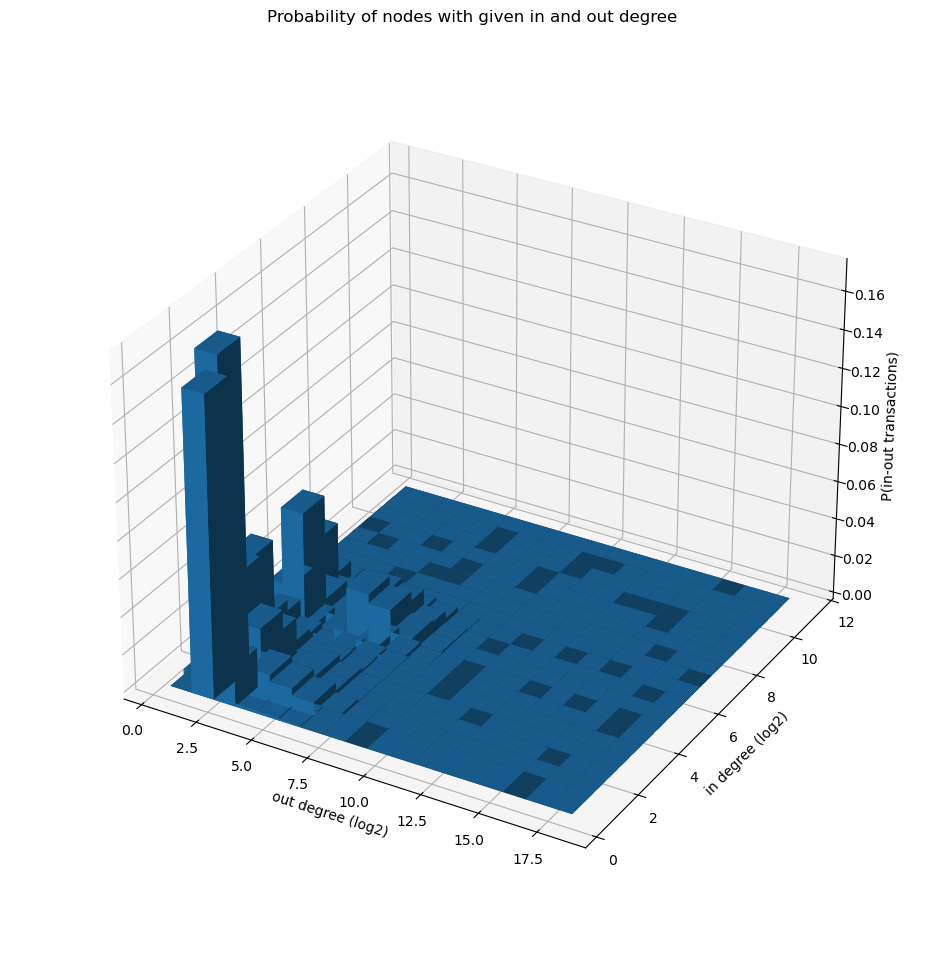

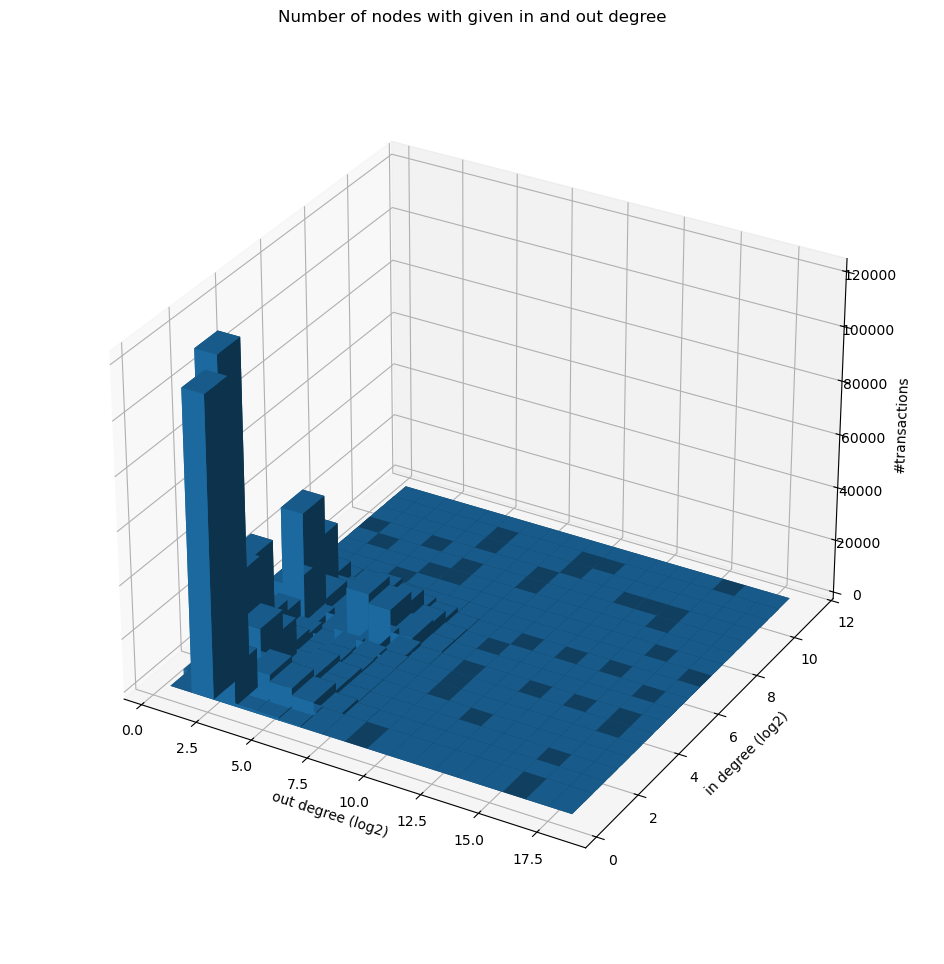

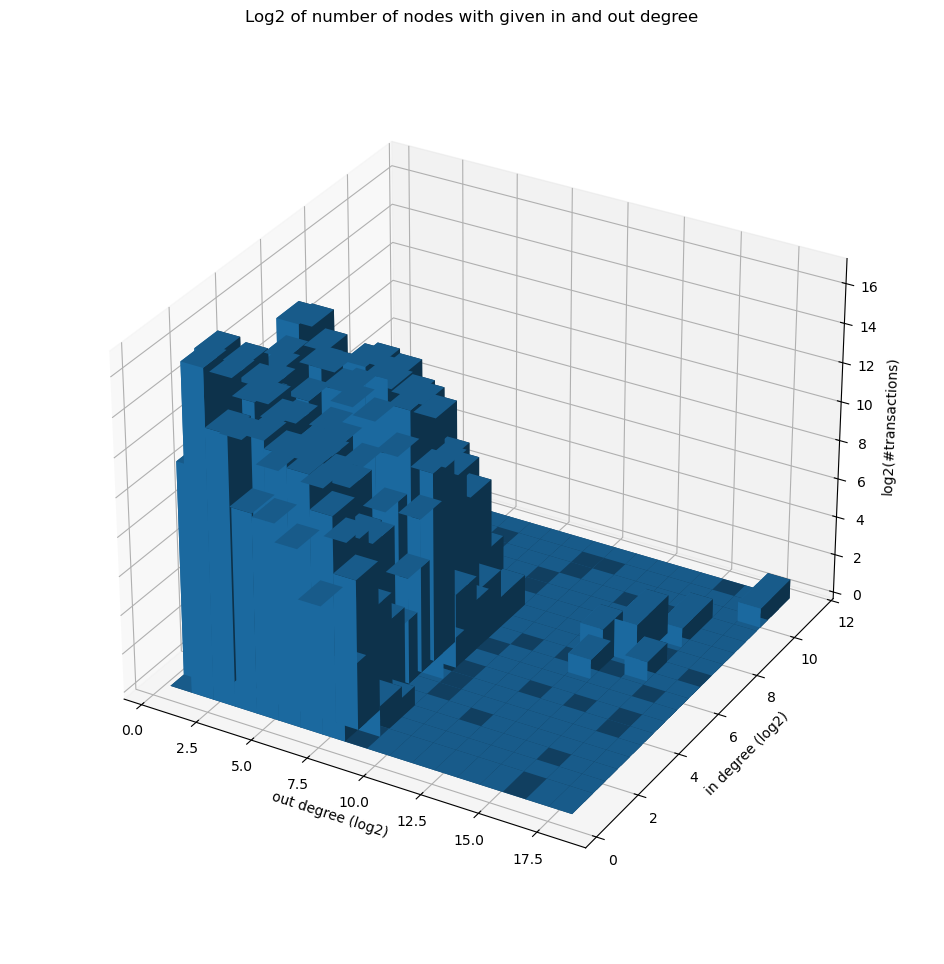

In [48]:
plot_degree_statistics(trans_graph)

## Analysis of the Graph's Connected Components

In [26]:
def print_connected_components_stats(g: Graph, table_title: str = "") -> tuple:
	"""Assumes the graph is directed.
	"""

	# Compute strongly and weakly connected components
	comp_label_scc, hist_scc = label_components(g, directed=True)
	comp_label_wcc, hist_wcc = label_components(g, directed=False)
	
	# Count the number of Sink nodes and Source nodes
	sink_nodes = sum(1 for v in g.vertices() if (v.out_degree() == 0 and v.in_degree() > 0))
	source_nodes = sum(1 for v in g.vertices() if (v.in_degree() == 0 and v.out_degree() > 0))
	self_transaction_nodes = sum(1 for v in g.vertices() if g.edge(v, v) is not None)

	# Create the table
	table = PrettyTable()
	table.field_names = ["Metric", "Value", "% of total nodes"]
	table.title = table_title
	table.align = "l"
 
	table.add_row(["Number of nodes", f"{g.num_vertices():,}", "-"])
	
	table.add_divider()
  
	# Add SCC metrics
	table.add_row(["Number of Strongly Connected Components", f"{len(hist_scc):,}", "-"])
	table.add_row(["Largest Strongly Connected Component size", f"{max(hist_scc):,}", "-"])
	table.add_row(["Average Strongly Connected Component size", f"{np.mean(hist_scc):,.1f}", "-"])
	table.add_row(["Median Strongly Connected Component size", f"{np.median(hist_scc):,.1f}", "-"])
	table.add_row(["Number of Singletons", f"{(hist_scc == 1).sum():,}", f"{(hist_scc == 1).sum()/g.num_vertices()*100:,.2f}%"])
	table.add_row(["Number of Sink nodes", f"{sink_nodes:,}", f"{sink_nodes/g.num_vertices()*100:,.2f}%"])
	table.add_row(["Number of Source nodes", f"{source_nodes:,}", f"{source_nodes/g.num_vertices()*100:,.2f}%"])

	table.add_divider()

	# Add WCC metrics
	table.add_row(["Number of Weakly Connected Components", f"{len(hist_wcc):,}", "-"])
	table.add_row(["Largest Weakly Connected Component size", f"{max(hist_wcc):,}", "-"])
	table.add_row(["Average Weakly Connected Component size", f"{np.mean(hist_wcc):,.1f}", "-"])
	table.add_row(["Median Weakly Connected Component size", f"{np.median(hist_wcc):,.1f}", "-"])
	table.add_row(["Number of Singletons", f"{(hist_wcc == 1).sum():,}", f"{(hist_wcc == 1).sum()/g.num_vertices()*100:,.2f}%"])
 
	table.add_divider()
	table.add_row(["Nodes with self-transactions", f"{self_transaction_nodes:,}", f"{self_transaction_nodes/g.num_vertices()*100:,.2f}%"])

	# Print the table
	print(table)
 
	return comp_label_scc, comp_label_wcc, hist_scc, hist_wcc


In [27]:
comp_label_scc, comp_label_wcc, hist_scc, hist_wcc = print_connected_components_stats(trans_graph, "Graph Connected Components Statistics")

+------------------------------------------------------------------------+
|                 Graph Connected Components Statistics                  |
+-------------------------------------------+---------+------------------+
| Metric                                    | Value   | % of total nodes |
+-------------------------------------------+---------+------------------+
| Number of nodes                           | 705,907 | -                |
+-------------------------------------------+---------+------------------+
| Number of Strongly Connected Components   | 683,530 | -                |
| Largest Strongly Connected Component size | 17,827  | -                |
| Average Strongly Connected Component size | 1.0     | -                |
| Median Strongly Connected Component size  | 1.0     | -                |
| Number of Singletons                      | 679,552 | 96.27%           |
| Number of Sink nodes                      | 24,624  | 3.49%            |
| Number of Source nodes 

## Analysis of the Money Laundering Subgraph

In [28]:
# Usa direttamente la property map come filtro
laundering_subgraph_view = GraphView(trans_graph, vfilt=trans_graph.vp.is_laundering)
bel_scc, comp_label_wcc, hist_scc, hist_wcc = print_connected_components_stats(laundering_subgraph_view, "Subgraph of Laundering Accounts Connected Components Statistics")

+----------------------------------------------------------------------+
|   Subgraph of Laundering Accounts Connected Components Statistics    |
+-------------------------------------------+-------+------------------+
| Metric                                    | Value | % of total nodes |
+-------------------------------------------+-------+------------------+
| Number of nodes                           | 5,304 | -                |
+-------------------------------------------+-------+------------------+
| Number of Strongly Connected Components   | 4,949 | -                |
| Largest Strongly Connected Component size | 13    | -                |
| Average Strongly Connected Component size | 1.1   | -                |
| Median Strongly Connected Component size  | 1.0   | -                |
| Number of Singletons                      | 4,663 | 87.91%           |
| Number of Sink nodes                      | 399   | 7.52%            |
| Number of Source nodes                    | 250  